In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('../final_merged_output.csv')
df = df[df['Year'] <= 2022]
chicago = df[df['City'] == 'Chicago']
ny = df[df['City'] == 'New York']
phoenix = df[df['City'] == 'Phoenix']
la = df[df['City'] == 'Los Angeles']
houston = df[df['City'] == 'Houston']
chicago.tail()

,City,Year,Quarter,index_nsa,Median Household Income,Total Population,INDPRO,VIXCLS,CPI,Unemployment Rate,City GDP
127,Chicago,2021,4,214.65,66576.0,2696561.00,100.939133,19.318636,4.697859,4.400000,770533358.0
128,Chicago,2022,1,221.00,67528.5,2688686.75,101.911200,25.349844,8.002800,4.866667,845186849.0
129,Chicago,2022,2,234.20,68481.0,2680812.50,102.896900,27.322077,8.002800,4.633333,845186849.0
130,Chicago,2022,3,235.88,69433.5,2672938.25,103.251133,24.792727,8.002800,4.766667,845186849.0
131,Chicago,2022,4,232.43,70386.0,2665064.00,102.792200,24.945077,8.002800,4.166667,845186849.0


In [ ]:
def features(df):
    # Feature importance analysis for predicting index_nsa (Chicago) using Linear Regression
    # Filter for Chicago and drop rows with missing target
    df = df.dropna(subset=['index_nsa'])

    # Select feature columns (exclude City/Year/Quarter/index_nsa)
    features = ['Median Household Income', 'Total Population', 'INDPRO', 'VIXCLS', 'CPI', 'Unemployment Rate', 'City GDP']
    features = [c for c in features if c in df.columns]

    if not features:
        raise ValueError('None of the expected feature columns are present in the dataframe.')

    # Prepare X/y, fill missing feature values with training medians
    X = df[features].copy()
    y = df['index_nsa'].astype(float)
    X_filled = X.fillna(X.median())

    # Standardize features so coefficients are comparable
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_filled)

    # Fit linear regression on all available Chicago rows (you can change to a train/test split if desired)
    model = LinearRegression()
    model.fit(X_scaled, y)

    # Standardized coefficients (since X_scaled is standardized)
    coef_series = pd.Series(model.coef_, index=features).sort_values(key=lambda s: s.abs(), ascending=False)

    # Permutation importance (R^2 importance)
    perm = permutation_importance(model, X_scaled, y, n_repeats=30, random_state=0, scoring='r2')
    perm_series = pd.Series(perm.importances_mean, index=features).sort_values(ascending=False)

    # Variance Inflation Factor (VIF) - use the filled (non-scaled) features
    X_vif = X_filled.copy()
    X_vif['const'] = 1
    vif_dict = {}
    for i, var in enumerate(features):
        vif = variance_inflation_factor(X_vif.values, i)
        vif_dict[var] = vif
    vif_series = pd.Series(vif_dict).sort_values(ascending=False)

    # OLS summary (for p-values and diagnostics) - use scaled X with constant
    X_ols = sm.add_constant(X_scaled)
    ols_model = sm.OLS(y, X_ols).fit()

    # Collect results into a DataFrame
    importance_df = pd.DataFrame({
        'Standardized_Coefficient': coef_series,
        'Permutation_Importance': perm_series,
        'VIF': vif_series
    }).fillna(0)

    # Display results
    print('\nStandardized coefficients (sorted):')
    print(coef_series)

    print('\nPermutation importance (R^2, sorted):')
    print(perm_series)

    print('\nVIF (sorted):')
    print(vif_series)

    print('\nOLS summary:')
    print(ols_model.summary())


In [21]:
features(chicago)


Standardized coefficients (sorted):
City GDP                   38.865802
Total Population           13.612226
CPI                         6.864656
INDPRO                      4.420920
Median Household Income     1.142678
VIXCLS                     -1.131016
Unemployment Rate           0.462170
dtype: float64

Permutation importance (R^2, sorted):
City GDP                   1.956854
Total Population           0.238298
CPI                        0.058308
INDPRO                     0.026217
Median Household Income    0.001630
VIXCLS                     0.001598
Unemployment Rate          0.000263
dtype: float64

VIF (sorted):
City GDP                   42.854852
Median Household Income    24.610036
INDPRO                     10.422142
Total Population            2.544793
Unemployment Rate           2.117417
VIXCLS                      1.346666
CPI                         1.309552
dtype: float64

OLS summary:
                            OLS Regression Results                            
D

Correlations with City GDP (sorted by absolute value):
Median Household Income    0.959
INDPRO                     0.887
Total Population          -0.585
CPI                       -0.061
VIXCLS                     0.045
Unemployment Rate          0.035
Name: City GDP, dtype: float64

Full correlation matrix (rounded):
                         Median Household Income  Total Population  INDPRO  \
Median Household Income                    1.000            -0.651   0.798   
Total Population                          -0.651             1.000  -0.332   
INDPRO                                     0.798            -0.332   1.000   
VIXCLS                                     0.073             0.198   0.042   
CPI                                        0.033            -0.075  -0.170   
Unemployment Rate                         -0.046            -0.120  -0.151   
City GDP                                   0.959            -0.585   0.887   

                         VIXCLS    CPI  Unemployment Ra

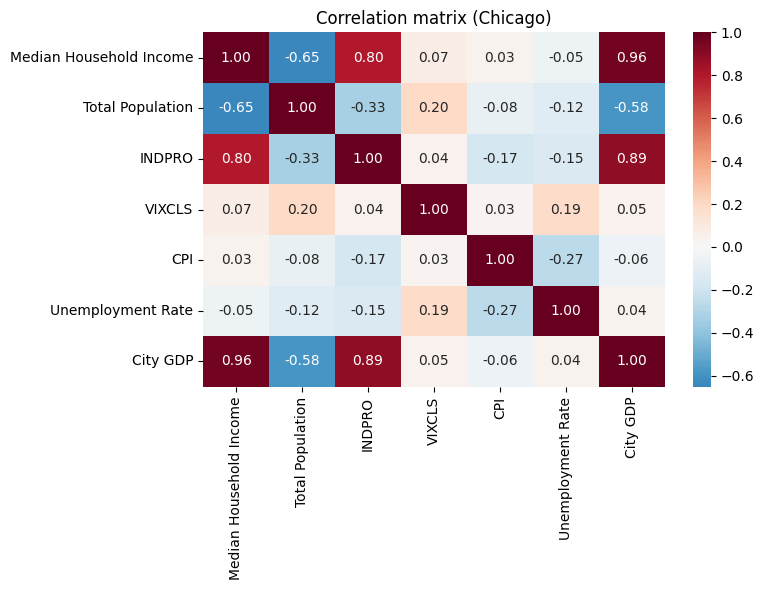

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
features = ['Median Household Income', 'Total Population', 'INDPRO', 'VIXCLS', 'CPI', 'Unemployment Rate', 'City GDP']
features = [c for c in features if c in chicago.columns]
if not features:
    raise ValueError('No feature columns found in chicago dataframe')

# Compute correlation matrix (pairwise Pearson)
corr = chicago[features].corr()

# Correlations with City GDP sorted by absolute value (exclude City GDP itself)
if 'City GDP' not in corr.columns:
    raise ValueError('City GDP not present in correlation matrix')

corr_with_city_gdp = corr['City GDP'].drop('City GDP').sort_values(key=lambda s: s.abs(), ascending=False)

print("Correlations with City GDP (sorted by absolute value):")
print(corr_with_city_gdp.round(3))

print("\nFull correlation matrix (rounded):")
print(corr.round(3))

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Correlation matrix (Chicago)')
plt.tight_layout()
plt.show()

In [22]:
features(ny)


Standardized coefficients (sorted):
Median Household Income    110.209840
City GDP                   -80.897706
INDPRO                      53.110891
CPI                         12.961200
Unemployment Rate            8.001977
Total Population            -1.390629
VIXCLS                      -0.797266
dtype: float64

Permutation importance (R^2, sorted):
Median Household Income    4.359282
City GDP                   2.337052
INDPRO                     1.015052
CPI                        0.060141
Unemployment Rate          0.022718
Total Population           0.000642
VIXCLS                     0.000335
dtype: float64

VIF (sorted):
Median Household Income    38.212571
City GDP                   37.036560
Total Population            8.070514
INDPRO                      6.061846
Unemployment Rate           1.570388
CPI                         1.398692
VIXCLS                      1.083165
dtype: float64

OLS summary:
                            OLS Regression Results                       

In [24]:
features(phoenix)


Standardized coefficients (sorted):
City GDP                   125.851834
INDPRO                     -57.756686
Unemployment Rate          -28.050293
Median Household Income     23.732742
CPI                         12.260438
Total Population           -10.526679
VIXCLS                      -3.119621
dtype: float64

Permutation importance (R^2, sorted):
City GDP                   3.696886
INDPRO                     0.780111
Unemployment Rate          0.183411
Median Household Income    0.131414
CPI                        0.033929
Total Population           0.025967
VIXCLS                     0.002416
dtype: float64

VIF (sorted):
City GDP                   38.215094
Median Household Income    26.105661
INDPRO                     18.314154
Total Population            9.146244
Unemployment Rate           2.960720
CPI                         2.071562
VIXCLS                      1.242176
dtype: float64

OLS summary:
                            OLS Regression Results                       

In [25]:
features(la)


Standardized coefficients (sorted):
City GDP                   99.492693
CPI                        19.193816
Total Population            9.529398
INDPRO                     -8.643204
Unemployment Rate          -6.705813
VIXCLS                     -5.398273
Median Household Income     0.616416
dtype: float64

Permutation importance (R^2, sorted):
City GDP                   1.724537
CPI                        0.062199
Total Population           0.016031
INDPRO                     0.012770
Unemployment Rate          0.008294
VIXCLS                     0.005243
Median Household Income    0.000058
dtype: float64

VIF (sorted):
City GDP                   132.961611
Total Population            29.074786
Median Household Income     28.830875
INDPRO                      27.176509
CPI                          2.935344
Unemployment Rate            2.171972
VIXCLS                       1.110082
dtype: float64

OLS summary:
                            OLS Regression Results                       

In [26]:
features(houston)


Standardized coefficients (sorted):
Median Household Income    44.393216
INDPRO                     15.615468
City GDP                   14.150620
Total Population            3.174746
CPI                         3.138675
VIXCLS                      3.134756
Unemployment Rate           1.303575
dtype: float64

Permutation importance (R^2, sorted):
Median Household Income    0.794437
INDPRO                     0.099253
City GDP                   0.081510
Total Population           0.004265
CPI                        0.003855
VIXCLS                     0.003847
Unemployment Rate          0.000774
dtype: float64

VIF (sorted):
City GDP                   90.793905
Total Population           67.804434
INDPRO                     23.457138
Median Household Income    11.377342
CPI                         2.659257
Unemployment Rate           2.217534
VIXCLS                      1.069480
dtype: float64

OLS summary:
                            OLS Regression Results                            
D